# Making Complex Decisions
---

This Jupyter notebook acts as supporting material for topics covered in **Chapter 17 Making Complex Decisions** of the book* Artificial Intelligence: A Modern Approach*. We make use of the implementations in mdp.py module. This notebook also includes a brief summary of the main topics as a review. Let us import everything from the mdp module to get started.

In [423]:
from mdp import *
from notebook import psource, pseudocode, plot_pomdp_utility

## CONTENTS

* Overview
* MDP
* Grid MDP
* Value Iteration
    * Value Iteration Visualization
* Policy Iteration
* POMDPs
* POMDP Value Iteration
    - Value Iteration Visualization

## OVERVIEW

Before we start playing with the actual implementations let us review a couple of things about MDPs.

- A stochastic process has the **Markov property** if the conditional probability distribution of future states of the process (conditional on both past and present states) depends only upon the present state, not on the sequence of events that preceded it.

    -- Source: [Wikipedia](https://en.wikipedia.org/wiki/Markov_property)

Often it is possible to model many different phenomena as a Markov process by being flexible with our definition of state.
   

- MDPs help us deal with fully-observable and non-deterministic/stochastic environments. For dealing with partially-observable and stochastic cases we make use of generalization of MDPs named POMDPs (partially observable Markov decision process).

Our overall goal to solve a MDP is to come up with a policy which guides us to select the best action in each state so as to maximize the expected sum of future rewards.

## MDP

To begin with let us look at the implementation of MDP class defined in mdp.py The docstring tells us what all is required to define a MDP namely - set of states, actions, initial state, transition model, and a reward function. Each of these are implemented as methods. Do not close the popup so that you can follow along the description of code below.

In [424]:
psource(MDP)

The **_ _init_ _** method takes in the following parameters:

- init: the initial state.
- actlist: List of actions possible in each state.
- terminals: List of terminal states where only possible action is exit
- gamma: Discounting factor. This makes sure that delayed rewards have less value compared to immediate ones.

**R** method returns the reward for each state by using the self.reward dict.

**T** method is not implemented and is somewhat different from the text. Here we return (probability, s') pairs where s' belongs to list of possible state by taking action a in state s.

**actions** method returns list of actions possible in each state. By default it returns all actions for states other than terminal states.


Now let us implement the simple MDP in the image below. States A, B have actions X, Y available in them. Their probabilities are shown just above the arrows. We start with using MDP as base class for our CustomMDP. Obviously we need to make a few changes to suit our case. We make use of a transition matrix as our transitions are not very simple.
<img src="files/images/mdp-a.png">

In [425]:
# Transition Matrix as nested dict. State -> Actions in state -> List of (Probability, State) tuples
t = {
    "A": {
            "X": [(0.3, "A"), (0.7, "B")],
            "Y": [(1.0, "A")]
         },
    "B": {
            "X": {(0.8, "End"), (0.2, "B")},
            "Y": {(1.0, "A")}
         },
    "End": {}
}

init = "A"

terminals = ["End"]

rewards = {
    "A": 5,
    "B": -10,
    "End": 100
}

In [426]:
class CustomMDP(MDP):
    def __init__(self, init, terminals, transition_matrix, reward = None, gamma=.9):
        # All possible actions.
        actlist = []
        for state in transition_matrix.keys():
            actlist.extend(transition_matrix[state])
        actlist = list(set(actlist))
        MDP.__init__(self, init, actlist, terminals, transition_matrix, reward, gamma=gamma)

    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else: 
            return self.t[state][action]

Finally we instantize the class with the parameters for our MDP in the picture.

In [427]:
our_mdp = CustomMDP(init, terminals, t, rewards, gamma=.9)

With this we have successfully represented our MDP. Later we will look at ways to solve this MDP.

## GRID MDP

Now we look at a concrete implementation that makes use of the MDP as base class. The GridMDP class in the mdp module is used to represent a grid world MDP like the one shown in  in **Fig 17.1** of the AIMA Book. We assume for now that the environment is _fully observable_, so that the agent always knows where it is. The code should be easy to understand if you have gone through the CustomMDP example.

In [428]:
psource(GridMDP)

The **_ _init_ _** method takes **grid** as an extra parameter compared to the MDP class. The grid is a nested list of rewards in states.

**go** method returns the state by going in particular direction by using vector_add.

**T** method is not implemented and is somewhat different from the text. Here we return (probability, s') pairs where s' belongs to list of possible state by taking action a in state s.

**actions** method returns list of actions possible in each state. By default it returns all actions for states other than terminal states.

**to_arrows** are used for representing the policy in a grid like format.

We can create a GridMDP like the one in **Fig 17.1** as follows: 

    GridMDP([[-0.04, -0.04, -0.04, +1],
            [-0.04, None,  -0.04, -1],
            [-0.04, -0.04, -0.04, -0.04]],
            terminals=[(3, 2), (3, 1)])
            
In fact the **sequential_decision_environment** in mdp module has been instantized using the exact same code.

In [429]:
sequential_decision_environment

# VALUE ITERATION

Now that we have looked how to represent MDPs. Let's aim at solving them. Our ultimate goal is to obtain an optimal policy. We start with looking at Value Iteration and a visualisation that should help us understanding it better.

We start by calculating Value/Utility for each of the states. The Value of each state is the expected sum of discounted future rewards given we start in that state and follow a particular policy $\pi$. The value or the utility of a state is given by

$$U(s)=R(s)+\gamma\max_{a\epsilon A(s)}\sum_{s'} P(s'\ |\ s,a)U(s')$$

This is called the Bellman equation. The algorithm Value Iteration (**Fig. 17.4** in the book) relies on finding solutions of this Equation. The intuition Value Iteration works is because values propagate through the state space by means of local updates. This point will we more clear after we encounter the visualisation. For more information you can refer to **Section 17.2** of the book. 


In [430]:
psource(value_iteration)

It takes as inputs two parameters, an MDP to solve and epsilon, the maximum error allowed in the utility of any state. It returns a dictionary containing utilities where the keys are the states and values represent utilities. <br> Value Iteration starts with arbitrary initial values for the utilities, calculates the right side of the Bellman equation and plugs it into the left hand side, thereby updating the utility of each state from the utilities of its neighbors. 
This is repeated until equilibrium is reached. 
It works on the principle of _Dynamic Programming_ - using precomputed information to simplify the subsequent computation. 
If $U_i(s)$ is the utility value for state $s$ at the $i$ th iteration, the iteration step, called Bellman update, looks like this:

$$ U_{i+1}(s) \leftarrow R(s) + \gamma \max_{a \epsilon A(s)} \sum_{s'} P(s'\ |\ s,a)U_{i}(s') $$

As you might have noticed, `value_iteration` has an infinite loop. How do we decide when to stop iterating? 
The concept of _contraction_ successfully explains the convergence of value iteration. 
Refer to **Section 17.2.3** of the book for a detailed explanation. 
In the algorithm, we calculate a value $delta$ that measures the difference in the utilities of the current time step and the previous time step. 

$$\delta = \max{(\delta, \begin{vmatrix}U_{i + 1}(s) - U_i(s)\end{vmatrix})}$$

This value of delta decreases as the values of $U_i$ converge.
We terminate the algorithm if the $\delta$ value is less than a threshold value determined by the hyperparameter _epsilon_.

$$\delta \lt \epsilon \frac{(1 - \gamma)}{\gamma}$$

To summarize, the Bellman update is a _contraction_ by a factor of $gamma$ on the space of utility vectors. 
Hence, from the properties of contractions in general, it follows that `value_iteration` always converges to a unique solution of the Bellman equations whenever $gamma$ is less than 1.
We then terminate the algorithm when a reasonable approximation is achieved.
In practice, it often occurs that the policy $pi$ becomes optimal long before the utility function converges. For the given 4 x 3 environment with $gamma = 0.9$, the policy $pi$ is optimal when $i = 4$ (at the 4th iteration), even though the maximum error in the utility function is stil 0.46. This can be clarified from **figure 17.6** in the book. Hence, to increase computational efficiency, we often use another method to solve MDPs called Policy Iteration which we will see in the later part of this notebook. 
<br>For now, let us solve the **sequential_decision_environment** GridMDP using `value_iteration`.

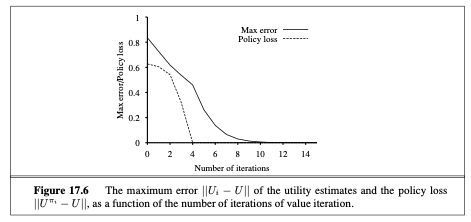

In [431]:
value_iteration(sequential_decision_environment)

{(0, 1): 0.3984432178350045,
 (1, 2): 0.649585681261095,
 (2, 1): 0.48644001739269643,
 (0, 0): 0.2962883154554812,
 (3, 1): -1.0,
 (2, 0): 0.3447542300124158,
 (3, 0): 0.12987274656746342,
 (0, 2): 0.5093943765842497,
 (2, 2): 0.7953620878466678,
 (1, 0): 0.25386699846479516,
 (3, 2): 1.0}

The pseudocode for the algorithm:

In [432]:
pseudocode("Value-Iteration")

### AIMA3e
__function__ VALUE-ITERATION(_mdp_, _&epsi;_) __returns__ a utility function  
&emsp;__inputs__: _mdp_, an MDP with states _S_, actions _A_(_s_), transition model _P_(_s&prime;_ &vert; _s_, _a_),  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;rewards _R_(_s_), discount _&gamma;_  
&emsp;&emsp;&emsp;_&epsi;_, the maximum error allowed in the utility of any state  
&emsp;__local variables__: _U_, _U&prime;_, vectors of utilities for states in _S_, initially zero  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&delta;_, the maximum change in the utility of any state in an iteration  

&emsp;__repeat__  
&emsp;&emsp;&emsp;_U_ &larr; _U&prime;_; _&delta;_ &larr; 0  
&emsp;&emsp;&emsp;__for each__ state _s_ in _S_ __do__  
&emsp;&emsp;&emsp;&emsp;&emsp;_U&prime;_\[_s_\] &larr; _R_(_s_) &plus; _&gamma;_ max<sub>_a_ &isin; _A_(_s_)</sub> &Sigma; _P_(_s&prime;_ &vert; _s_, _a_) _U_\[_s&prime;_\]  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ &vert; _U&prime;_\[_s_\] &minus; _U_\[_s_\]  &vert; &gt; _&delta;_ __then__ _&delta;_ &larr; &vert; _U&prime;_\[_s_\] &minus; _U_\[_s_\]  &vert;  
&emsp;__until__ _&delta;_ &lt; _&epsi;_(1 &minus; _&gamma;_)&sol;_&gamma;_  
&emsp;__return__ _U_  

---
__Figure ??__ The value iteration algorithm for calculating utilities of states. The termination condition is from Equation (__??__).

---

## AIMA4e  
__function__ VALUE-ITERATION(_mdp_, _&epsi;_) __returns__ a utility function  
&emsp;__inputs__: _mdp_, an MDP with states _S_, actions _A_(_s_), transition model _P_(_s&prime;_ &vert; _s_, _a_),  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;rewards _R_(_s_,_a_,_s&prime;_), discount _&gamma;_  
&emsp;&emsp;&emsp;_&epsi;_, the maximum error allowed in the utility of any state  
&emsp;__local variables__: _U_, _U&prime;_, vectors of utilities for states in _S_, initially zero  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&delta;_, the maximum change in the utility of any state in an iteration  

&emsp;__repeat__  
&emsp;&emsp;&emsp;_U_ &larr; _U&prime;_; _&delta;_ &larr; 0  
&emsp;&emsp;&emsp;__for each__ state _s_ in _S_ __do__  
&emsp;&emsp;&emsp;&emsp;&emsp;_U&prime;_\[_s_\] &larr; max<sub>_a_ &isin; _A_(_s_)</sub> Q-VALUE(_mdp_,_s_,_a_,_U_)  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ &vert; _U&prime;_\[_s_\] &minus; _U_\[_s_\]  &vert; &gt; _&delta;_ __then__ _&delta;_ &larr; &vert; _U&prime;_\[_s_\] &minus; _U_\[_s_\]  &vert;  
&emsp;__until__ _&delta;_ &lt; _&epsi;_(1 &minus; _&gamma;_)&sol;_&gamma;_  
&emsp;__return__ _U_  

---
__Figure ??__ The value iteration algorithm for calculating utilities of states. The termination condition is from Equation (__??__).
~

### AIMA3e
__function__ VALUE-ITERATION(_mdp_, _&epsi;_) __returns__ a utility function  
&emsp;__inputs__: _mdp_, an MDP with states _S_, actions _A_(_s_), transition model _P_(_s&prime;_ &vert; _s_, _a_),  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;rewards _R_(_s_), discount _&gamma;_  
&emsp;&emsp;&emsp;_&epsi;_, the maximum error allowed in the utility of any state  
&emsp;__local variables__: _U_, _U&prime;_, vectors of utilities for states in _S_, initially zero  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&delta;_, the maximum change in the utility of any state in an iteration  

&emsp;__repeat__  
&emsp;&emsp;&emsp;_U_ &larr; _U&prime;_; _&delta;_ &larr; 0  
&emsp;&emsp;&emsp;__for each__ state _s_ in _S_ __do__  
&emsp;&emsp;&emsp;&emsp;&emsp;_U&prime;_\[_s_\] &larr; _R_(_s_) &plus; _&gamma;_ max<sub>_a_ &isin; _A_(_s_)</sub> &Sigma; _P_(_s&prime;_ &vert; _s_, _a_) _U_\[_s&prime;_\]  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ &vert; _U&prime;_\[_s_\] &minus; _U_\[_s_\]  &vert; &gt; _&delta;_ __then__ _&delta;_ &larr; &vert; _U&prime;_\[_s_\] &minus; _U_\[_s_\]  &vert;  
&emsp;__until__ _&delta;_ &lt; _&epsi;_(1 &minus; _&gamma;_)&sol;_&gamma;_  
&emsp;__return__ _U_  

---
__Figure ??__ The value iteration algorithm for calculating utilities of states. The termination condition is from Equation (__??__).

## VALUE ITERATION VISUALIZATION

To illustrate that values propagate out of states let us create a simple visualisation. We will be using a modified version of the value_iteration function which will store U over time. We will also remove the parameter epsilon and instead add the number of iterations we want.

In [433]:
def value_iteration_instru(mdp, iterations=20):
    U_over_time = []
    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for _ in range(iterations):
        U = U1.copy()
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
        U_over_time.append(U)
    return U_over_time

Next, we define a function to create the visualisation from the utilities returned by **value_iteration_instru**. The reader need not concern himself with the code that immediately follows as it is the usage of Matplotib with IPython Widgets. If you are interested in reading more about these visit [ipywidgets.readthedocs.io](http://ipywidgets.readthedocs.io)

In [434]:
columns = 4
rows = 3
U_over_time = value_iteration_instru(sequential_decision_environment)

In [435]:
%matplotlib inline
from notebook import make_plot_grid_step_function

plot_grid_step = make_plot_grid_step_function(columns, rows, U_over_time)

In [436]:
import ipywidgets as widgets
from IPython.display import display
from notebook import make_visualize

iteration_slider = widgets.IntSlider(min=1, max=15, step=1, value=0)
w=widgets.interactive(plot_grid_step,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:',options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])
a = widgets.interactive(
    visualize_callback,
    visualize=visualize_button,   # ใช้ชื่อพารามิเตอร์ใน callback จริง ๆ
    time_step=time_select
)


interactive(children=(IntSlider(value=1, description='iteration', max=15, min=1), Output()), _dom_classes=('wi…

Move the slider above to observe how the utility changes across iterations. It is also possible to move the slider using arrow keys or to jump to the value by directly editing the number with a double click. The **Visualize Button** will automatically animate the slider for you. The **Extra Delay Box** allows you to set time delay in seconds upto one second for each time step. There is also an interactive editor for grid-world problems `grid_mdp.py` in the gui folder for you to play around with.

# POLICY ITERATION

We have already seen that value iteration converges to the optimal policy long before it accurately estimates the utility function. 
If one action is clearly better than all the others, then the exact magnitude of the utilities in the states  involved need not be precise. 
The policy iteration algorithm works on this insight. 
The algorithm executes two fundamental steps:
* **Policy evaluation**: Given a policy _&#960;&#7522;_, calculate _U&#7522; = U(&#960;&#7522;)_, the utility of each state if _&#960;&#7522;_ were to be executed.
* **Policy improvement**: Calculate a new policy _&#960;&#7522;&#8330;&#8321;_ using one-step look-ahead based on the utility values calculated.

The algorithm terminates when the policy improvement step yields no change in the utilities. 
Refer to **Figure 17.6** in the book to see how this is an improvement over value iteration.
We now have a simplified version of the Bellman equation

$$U_i(s) = R(s) + \gamma \sum_{s'}P(s'\ |\ s, \pi_i(s))U_i(s')$$

An important observation in this equation is that this equation doesn't have the `max` operator, which makes it linear.
For _n_ states, we have _n_ linear equations with _n_ unknowns, which can be solved exactly in time _**O(n&#179;)**_.
For more implementational details, have a look at **Section 17.3**.
Let us now look at how the expected utility is found and how `policy_iteration` is implemented.

In [437]:
psource(expected_utility)

In [438]:
psource(policy_iteration)

<br>Fortunately, it is not necessary to do _exact_ policy evaluation. 
The utilities can instead be reasonably approximated by performing some number of simplified value iteration steps.
The simplified Bellman update equation for the process is

$$U_{i+1}(s) \leftarrow R(s) + \gamma\sum_{s'}P(s'\ |\ s,\pi_i(s))U_{i}(s')$$

and this is repeated _k_ times to produce the next utility estimate. This is called _modified policy iteration_.

In [439]:
psource(policy_evaluation)

Let us now solve **`sequential_decision_environment`** using `policy_iteration`.

In [440]:
policy_iteration(sequential_decision_environment)

{(0, 1): (0, 1),
 (1, 2): (1, 0),
 (2, 1): (0, 1),
 (0, 0): (0, 1),
 (3, 1): None,
 (2, 0): (0, 1),
 (3, 0): (-1, 0),
 (0, 2): (1, 0),
 (2, 2): (1, 0),
 (1, 0): (1, 0),
 (3, 2): None}

In [441]:
pseudocode('Policy-Iteration')

### AIMA3e
__function__ POLICY-ITERATION(_mdp_) __returns__ a policy  
&emsp;__inputs__: _mdp_, an MDP with states _S_, actions _A_(_s_), transition model _P_(_s&prime;_ &vert; _s_, _a_)  
&emsp;__local variables__: _U_, a vector of utilities for states in _S_, initially zero  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&pi;_, a policy vector indexed by state, initially random  

&emsp;__repeat__  
&emsp;&emsp;&emsp;_U_ &larr; POLICY\-EVALUATION(_&pi;_, _U_, _mdp_)  
&emsp;&emsp;&emsp;_unchanged?_ &larr; true  
&emsp;&emsp;&emsp;__for each__ state _s_ __in__ _S_ __do__  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ max<sub>_a_ &isin; _A_(_s_)</sub> &Sigma;<sub>_s&prime;_</sub> _P_(_s&prime;_ &vert; _s_, _a_) _U_\[_s&prime;_\] &gt; &Sigma;<sub>_s&prime;_</sub> _P_(_s&prime;_ &vert; _s_, _&pi;_\[_s_\]) _U_\[_s&prime;_\] __then do__  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&pi;_\[_s_\] &larr; argmax<sub>_a_ &isin; _A_(_s_)</sub> &Sigma;<sub>_s&prime;_</sub> _P_(_s&prime;_ &vert; _s_, _a_) _U_\[_s&prime;_\]  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_unchanged?_ &larr; false  
&emsp;__until__ _unchanged?_  
&emsp;__return__ _&pi;_  

---
__Figure ??__ The policy iteration algorithm for calculating an optimal policy.

---
  
## AIMA4e  
__function__ POLICY-ITERATION(_mdp_) __returns__ a policy  
&emsp;__inputs__: _mdp_, an MDP with states _S_, actions _A_(_s_), transition model _P_(_s&prime;_ &vert; _s_, _a_)  
&emsp;__local variables__: _U_, a vector of utilities for states in _S_, initially zero  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&pi;_, a policy vector indexed by state, initially random  
  
&emsp;__repeat__  
&emsp;&emsp;&emsp;_U_ &larr; POLICY\-EVALUATION(_&pi;_, _U_, _mdp_)  
&emsp;&emsp;&emsp;_unchanged?_ &larr; true  
&emsp;&emsp;&emsp;__for each__ state _s_ __in__ _S_ __do__  
&emsp;&emsp;&emsp;&emsp;&emsp;_a <sup> &#x2a; </sup>_ &larr; argmax<sub>_a_ &isin; _A_(_s_)</sub> Q-VALUE(_mdp_,_s_,_a_,_U_)  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ Q-VALUE(_mdp_,_s_,_a<sup>&#x2a;</sup>_,_U_) &gt; Q-VALUE(_mdp_,_s_,_&pi;_\[_s_\],_U_) __then do__    
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&pi;_\[_s_\] &larr; _a<sup>&#x2a;</sup>_ ; _unchanged?_ &larr; false  
&emsp;__until__ _unchanged?_  
&emsp;__return__ _&pi;_  

---
__Figure ??__ The policy iteration algorithm for calculating an optimal policy.

### AIMA3e
__function__ POLICY-ITERATION(_mdp_) __returns__ a policy  
&emsp;__inputs__: _mdp_, an MDP with states _S_, actions _A_(_s_), transition model _P_(_s&prime;_ &vert; _s_, _a_)  
&emsp;__local variables__: _U_, a vector of utilities for states in _S_, initially zero  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&pi;_, a policy vector indexed by state, initially random  

&emsp;__repeat__  
&emsp;&emsp;&emsp;_U_ &larr; POLICY\-EVALUATION(_&pi;_, _U_, _mdp_)  
&emsp;&emsp;&emsp;_unchanged?_ &larr; true  
&emsp;&emsp;&emsp;__for each__ state _s_ __in__ _S_ __do__  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ max<sub>_a_ &isin; _A_(_s_)</sub> &Sigma;<sub>_s&prime;_</sub> _P_(_s&prime;_ &vert; _s_, _a_) _U_\[_s&prime;_\] &gt; &Sigma;<sub>_s&prime;_</sub> _P_(_s&prime;_ &vert; _s_, _&pi;_\[_s_\]) _U_\[_s&prime;_\] __then do__  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&pi;_\[_s_\] &larr; argmax<sub>_a_ &isin; _A_(_s_)</sub> &Sigma;<sub>_s&prime;_</sub> _P_(_s&prime;_ &vert; _s_, _a_) _U_\[_s&prime;_\]  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_unchanged?_ &larr; false  
&emsp;__until__ _unchanged?_  
&emsp;__return__ _&pi;_  

---
__Figure ??__ The policy iteration algorithm for calculating an optimal policy.

## Sequential Decision Problems

Now that we have the tools required to solve MDPs, let us see how Sequential Decision Problems can be solved step by step and how a few built-in tools in the GridMDP class help us better analyse the problem at hand. 
As always, we will work with the grid world from **Figure 17.1** from the book.
![title](images/grid_mdp.jpg)
<br>This is the environment for our agent.
We assume for now that the environment is _fully observable_, so that the agent always knows where it is.
We also assume that the transitions are **Markovian**, that is, the probability of reaching state $s'$ from state $s$ depends only on $s$ and not on the history of earlier states.
Almost all stochastic decision problems can be reframed as a Markov Decision Process just by tweaking the definition of a _state_ for that particular problem.
<br>
However, the actions of our agent in this environment are unreliable. In other words, the motion of our agent is stochastic. 
<br><br>
More specifically, the agent may - 
* move correctly in the intended direction with a probability of _0.8_,  
* move $90^\circ$ to the right of the intended direction with a probability 0.1
* move $90^\circ$ to the left of the intended direction with a probability 0.1
<br><br>
The agent stays put if it bumps into a wall.
![title](images/grid_mdp_agent.jpg)

These properties of the agent are called the transition properties and are hardcoded into the GridMDP class as you can see below.

In [442]:
psource(GridMDP.T)

To completely define our task environment, we need to specify the utility function for the agent. 
This is the function that gives the agent a rough estimate of how good being in a particular state is, or how much _reward_ an agent receives by being in that state.
The agent then tries to maximize the reward it gets.
As the decision problem is sequential, the utility function will depend on a sequence of states rather than on a single state.
For now, we simply stipulate that in each state $s$, the agent receives a finite reward $R(s)$.

For any given state, the actions the agent can take are encoded as given below:
- Move Up: (0, 1)
- Move Down: (0, -1)
- Move Left: (-1, 0)
- Move Right: (1, 0)
- Do nothing: `None`

We now wonder what a valid solution to the problem might look like. 
We cannot have fixed action sequences as the environment is stochastic and we can eventually end up in an undesirable state.
Therefore, a solution must specify what the agent shoulddo for _any_ state the agent might reach.
<br>
Such a solution is known as a **policy** and is usually denoted by $\pi$.
<br>
The **optimal policy** is the policy that yields the highest expected utility an is usually denoted by $\pi^*$.
<br>
The `GridMDP` class has a useful method `to_arrows` that outputs a grid showing the direction the agent should move, given a policy.
We will use this later to better understand the properties of the environment.

In [443]:
psource(GridMDP.to_arrows)

This method directly encodes the actions that the agent can take (described above) to characters representing arrows and shows it in a grid format for human visalization purposes. 
It converts the received policy from a `dictionary` to a grid using the `to_grid` method.

In [444]:
psource(GridMDP.to_grid)

Now that we have all the tools required and a good understanding of the agent and the environment, we consider some cases and see how the agent should behave for each case.

### Case 1
---
R(s) = -0.04 in all states except terminal states

In [445]:
# Note that this environment is also initialized in mdp.py by default
sequential_decision_environment = GridMDP([[-0.04, -0.04, -0.04, +1],
                                           [-0.04, None, -0.04, -1],
                                           [-0.04, -0.04, -0.04, -0.04]],
                                          terminals=[(3, 2), (3, 1)])

We will use the `best_policy` function to find the best policy for this environment.
But, as you can see, `best_policy` requires a utility function as well.
We already know that the utility function can be found by `value_iteration`.
Hence, our best policy is:

In [446]:
pi = best_policy(sequential_decision_environment, value_iteration(sequential_decision_environment, .001))

We can now use the `to_arrows` method to see how our agent should pick its actions in the environment.

In [447]:
from utils import print_table
print_table(sequential_decision_environment.to_arrows(pi))

>   >      >   .
^   None   ^   .
^   >      ^   <


This is exactly the output we expected
<br>
![title](images/-0.04.jpg)
<br>
Notice that, because the cost of taking a step is fairly small compared with the penalty for ending up in `(4, 2)` by accident, the optimal policy is conservative. 
In state `(3, 1)` it recommends taking the long way round, rather than taking the shorter way and risking getting a large negative reward of -1 in `(4, 2)`.

### Case 2
---
R(s) = -0.4 in all states except in terminal states

In [448]:
sequential_decision_environment = GridMDP([[-0.4, -0.4, -0.4, +1],
                                           [-0.4, None, -0.4, -1],
                                           [-0.4, -0.4, -0.4, -0.4]],
                                          terminals=[(3, 2), (3, 1)])

In [449]:
pi = best_policy(sequential_decision_environment, value_iteration(sequential_decision_environment, .001))
from utils import print_table
print_table(sequential_decision_environment.to_arrows(pi))

>   >      >   .
^   None   ^   .
^   >      ^   <


This is exactly the output we expected
![title](images/-0.4.jpg)

As the reward for each state is now more negative, life is certainly more unpleasant.
The agent takes the shortest route to the +1 state and is willing to risk falling into the -1 state by accident.

### Case 3
---
R(s) = -4 in all states except terminal states

In [450]:
sequential_decision_environment = GridMDP([[-4, -4, -4, +1],
                                           [-4, None, -4, -1],
                                           [-4, -4, -4, -4]],
                                          terminals=[(3, 2), (3, 1)])

In [451]:
pi = best_policy(sequential_decision_environment, value_iteration(sequential_decision_environment, .001))
from utils import print_table
print_table(sequential_decision_environment.to_arrows(pi))

>   >      >   .
^   None   >   .
>   >      >   ^


This is exactly the output we expected
![title](images/-4.jpg)

The living reward for each state is now lower than the least rewarding terminal. Life is so _painful_ that the agent heads for the nearest exit as even the worst exit is less painful than any living state.

### Case 4
---
R(s) = 4 in all states except terminal states

In [452]:
sequential_decision_environment = GridMDP([[4, 4, 4, +1],
                                           [4, None, 4, -1],
                                           [4, 4, 4, 4]],
                                          terminals=[(3, 2), (3, 1)])

In [453]:
pi = best_policy(sequential_decision_environment, value_iteration(sequential_decision_environment, .001))
from utils import print_table
print_table(sequential_decision_environment.to_arrows(pi))

>   >      <   .
>   None   <   .
>   >      >   v


In this case, the output we expect is
![title](images/4.jpg)
<br>
As life is positively enjoyable and the agent avoids _both_ exits.
Even though the output we get is not exactly what we want, it is definitely not wrong.
The scenario here requires the agent to anything but reach a terminal state, as this is the only way the agent can maximize its reward (total reward tends to infinity), and the program does just that.
<br>
Currently, the GridMDP class doesn't support an explicit marker for a "do whatever you like" action or a "don't care" condition.
You can however, extend the class to do so.
<br>
For in-depth knowledge about sequential decision problems, refer **Section 17.1** in the AIMA book.

## POMDP
---
Partially Observable Markov Decision Problems

In retrospect, a Markov decision process or MDP is defined as:
- a sequential decision problem for a fully observable, stochastic environment with a Markovian transition model and additive rewards.

An MDP consists of a set of states (with an initial state $s_0$); a set $A(s)$ of actions
in each state; a transition model $P(s' | s, a)$; and a reward function $R(s)$.

The MDP seeks to make sequential decisions to occupy states so as to maximise some combination of the reward function $R(s)$.

The characteristic problem of the MDP is hence to identify the optimal policy function $\pi^*(s)$ that provides the _utility-maximising_ action $a$ to be taken when the current state is $s$.

### Belief vector

**Note**: The book refers to the _belief vector_ as the _belief state_. We use the latter terminology here to retain our ability to refer to the belief vector as a _probability distribution over states_.

The solution of an MDP is subject to certain properties of the problem which are assumed and justified in [Section 17.1]. One critical assumption is that the agent is **fully aware of its current state at all times**.

A tedious (but rewarding, as we will see) way of expressing this is in terms of the **belief vector** $b$ of the agent. The belief vector is a function mapping states to probabilities or certainties of being in those states.

Consider an agent that is fully aware that it is in state $s_i$ in the statespace $(s_1, s_2, ... s_n)$ at the current time.

Its belief vector is the vector $(b(s_1), b(s_2), ... b(s_n))$ given by the function $b(s)$:
\begin{align*}
b(s) &= 0 \quad \text{if }s \neq s_i \\ &= 1 \quad \text{if } s = s_i
\end{align*}

Note that $b(s)$ is a probability distribution that necessarily sums to $1$ over all $s$.



### POMDPs - a conceptual outline

The POMDP really has only two modifications to the **problem formulation** compared to the MDP.

- **Belief state** - In the real world, the current state of an agent is often not known with complete certainty. This makes the concept of a belief vector extremely relevant. It allows the agent to represent different degrees of certainty with which it _believes_ it is in each state.

- **Evidence percepts** - In the real world, agents often have certain kinds of evidence, collected from sensors. They can use the probability distribution of observed evidence, conditional on state, to consolidate their information. This is a known distribution $P(e\ |\ s)$ - $e$ being an evidence, and $s$ being the state it is conditional on.

Consider the world we used for the MDP. 

![title](images/grid_mdp.jpg)

#### Using the belief vector
An agent beginning at $(1, 1)$ may not be certain that it is indeed in $(1, 1)$. Consider a belief vector $b$ such that:
\begin{align*}
    b((1,1)) &= 0.8 \\
    b((2,1)) &= 0.1 \\
    b((1,2)) &= 0.1 \\
    b(s) &= 0 \quad \quad \forall \text{ other } s
\end{align*}

By horizontally catenating each row, we can represent this as an 11-dimensional vector (omitting $(2, 2)$).

Thus, taking $s_1 = (1, 1)$, $s_2 = (1, 2)$, ... $s_{11} = (4,3)$, we have $b$:

$b = (0.8, 0.1, 0, 0, 0.1, 0, 0, 0, 0, 0, 0)$ 

This fully represents the certainty to which the agent is aware of its state.

#### Using evidence
The evidence observed here could be the number of adjacent 'walls' or 'dead ends' observed by the agent. We assume that the agent cannot 'orient' the walls - only count them.

In this case, $e$ can take only two values, 1 and 2. This gives $P(e\ |\ s)$ as:
\begin{align*}
    P(e=2\ |\ s) &= \frac{1}{7} \quad \forall \quad s \in \{s_1, s_2, s_4, s_5, s_8, s_9, s_{11}\}\\
    P(e=1\ |\ s) &= \frac{1}{4} \quad \forall \quad s \in \{s_3, s_6, s_7, s_{10}\} \\
    P(e\ |\ s) &= 0 \quad \forall \quad \text{ other } s, e
\end{align*}

Note that the implications of the evidence on the state must be known **a priori** to the agent. Ways of reliably learning this distribution from percepts are beyond the scope of this notebook.

### POMDPs - a rigorous outline

A POMDP is thus a sequential decision problem for for a *partially* observable, stochastic environment with a Markovian transition model, a known 'sensor model' for inferring state from observation, and additive rewards. 

Practically, a POMDP has the following, which an MDP also has:
- a set of states, each denoted by $s$
- a set of actions available in each state, $A(s)$
- a reward accrued on attaining some state, $R(s)$
- a transition probability $P(s'\ |\ s, a)$ of action $a$ changing the state from $s$ to $s'$

And the following, which an MDP does not:
- a sensor model $P(e\ |\ s)$ on evidence conditional on states

Additionally, the POMDP is now uncertain of its current state hence has:
- a belief vector $b$ representing the certainty of being in each state (as a probability distribution)


#### New uncertainties

It is useful to intuitively appreciate the new uncertainties that have arisen in the agent's awareness of its own state.

- At any point, the agent has belief vector $b$, the distribution of its believed likelihood of being in each state $s$.
- For each of these states $s$ that the agent may **actually** be in, it has some set of actions given by $A(s)$.
- Each of these actions may transport it to some other state $s'$, assuming an initial state $s$, with probability $P(s'\ |\ s, a)$
- Once the action is performed, the agent receives a percept $e$. $P(e\ |\ s)$ now tells it the chances of having perceived $e$ for each state $s$. The agent must use this information to update its new belief state appropriately.

#### Evolution of the belief vector - the `FORWARD` function

The new belief vector $b'(s')$ after an action $a$ on the belief vector $b(s)$ and the noting of evidence $e$ is:
$$ b'(s') = \alpha P(e\ |\ s') \sum_s P(s'\ | s, a) b(s)$$ 

where $\alpha$ is a normalising constant (to retain the interpretation of $b$ as a probability distribution.

This equation is just counts the sum of likelihoods of going to a state $s'$ from every possible state $s$, times the initial likelihood of being in each $s$. This is multiplied by the likelihood that the known evidence actually implies the new state $s'$. 

This function is represented as `b' = FORWARD(b, a, e)`

#### Probability distribution of the evolving belief vector

The goal here is to find $P(b'\ |\ b, a)$ - the probability that action $a$ transforms belief vector $b$ into belief vector $b'$. The following steps illustrate this -

The probability of observing evidence $e$ when action $a$ is enacted on belief vector $b$ can be distributed over each possible new state $s'$ resulting from it:
\begin{align*}
    P(e\ |\ b, a) &= \sum_{s'} P(e\ |\ b, a, s') P(s'\ |\ b, a) \\
                  &= \sum_{s'} P(e\ |\ s') P(s'\ |\ b, a) \\
                  &= \sum_{s'} P(e\ |\ s') \sum_s P(s'\ |\ s, a) b(s)
\end{align*}

The probability of getting belief vector $b'$ from $b$ by application of action $a$ can thus be summed over all possible evidences $e$:
\begin{align*}
    P(b'\ |\ b, a) &= \sum_{e} P(b'\ |\ b, a, e) P(e\ |\ b, a) \\
                  &= \sum_{e} P(b'\ |\ b, a, e) \sum_{s'} P(e\ |\ s') \sum_s P(s'\ |\ s, a) b(s)
\end{align*}

where $P(b'\ |\ b, a, e) = 1$ if $b' = $ `FORWARD(b, a, e)` and $= 0$ otherwise.

Given initial and final belief states $b$ and $b'$, the transition probabilities still depend on the action $a$ and observed evidence $e$. Some belief states may be achievable by certain actions, but have non-zero probabilities for states prohibited by the evidence $e$. Thus, the above condition thus ensures that only valid combinations of $(b', b, a, e)$ are considered.

#### A modified rewardspace

For MDPs, the reward space was simple - one reward per available state. However, for a belief vector $b(s)$, the expected reward is now:
$$\rho(b) = \sum_s b(s) R(s)$$

Thus, as the belief vector can take infinite values of the distribution over states, so can the reward for each belief vector vary over a hyperplane in the belief space, or space of states (planes in an $N$-dimensional space are formed by a linear combination of the axes).

Now that we know the basics, let's have a look at the `POMDP` class.

In [454]:
psource(POMDP)

The `POMDP` class includes all variables of the `MDP` class and additionally also stores the sensor model in `e_prob`.
<br>
<br>
`remove_dominated_plans`, `remove_dominated_plans_fast`, `generate_mapping` and `max_difference` are helper methods for `pomdp_value_iteration` which will be explained shortly.

To understand how we can model a partially observable MDP, let's take a simple example.
Let's consider a simple two state world.
The states are labelled 0 and 1, with the reward at state 0 being 0 and at state 1 being 1.
<br>
There are two actions:
<br>
`Stay`: stays put with probability 0.9 and
`Go`: switches to the other state with probability 0.9.
<br>
For now, let's assume the discount factor `gamma` to be 1.
<br>
The sensor reports the correct state with probability 0.6.
<br>
This is a simple problem with a trivial solution.
Obviously the agent should `Stay` when it thinks it is in state 1 and `Go` when it thinks it is in state 0.
<br>
The belief space can be viewed as one-dimensional because the two probabilities must sum to 1.

Let's model this POMDP using the `POMDP` class.

In [455]:
# transition probability P(s'|s,a)
t_prob = [[[0.9, 0.1], [0.1, 0.9]], [[0.1, 0.9], [0.9, 0.1]]]
# evidence function P(e|s)
e_prob = [[[0.6, 0.4], [0.4, 0.6]], [[0.6, 0.4], [0.4, 0.6]]]
# reward function
rewards = [[0.0, 0.0], [1.0, 1.0]]
# discount factor
gamma = 0.95
# actions
actions = ('0', '1')
# states
states = ('0', '1')

In [456]:
pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)

We have defined our `POMDP` object.

## POMDP VALUE ITERATION
Defining a POMDP is useless unless we can find a way to solve it. As POMDPs can have infinitely many belief states, we cannot calculate one utility value for each state as we did in `value_iteration` for MDPs.
<br>
Instead of thinking about policies, we should think about conditional plans and how the expected utility of executing a fixed conditional plan varies with the initial belief state.
<br>
If we bound the depth of the conditional plans, then there are only finitely many such plans and the continuous space of belief states will generally be divided inte _regions_, each corresponding to a particular conditional plan that is optimal in that region. The utility function, being the maximum of a collection of hyperplanes, will be piecewise linear and convex.
<br>
For the one-step plans `Stay` and `Go`, the utility values are as follows
<br>
<br>
$$\alpha_{|Stay|}(0) = R(0) + \gamma(0.9R(0) + 0.1R(1)) = 0.1$$
$$\alpha_{|Stay|}(1) = R(1) + \gamma(0.9R(1) + 0.1R(0)) = 1.9$$
$$\alpha_{|Go|}(0) = R(0) + \gamma(0.9R(1) + 0.1R(0)) = 0.9$$
$$\alpha_{|Go|}(1) = R(1) + \gamma(0.9R(0) + 0.1R(1)) = 1.1$$

The utility function can be found by `pomdp_value_iteration`.
<br>
To summarize, it generates a set of all plans consisting of an action and, for each possible next percept, a plan in U with computed utility vectors.
The dominated plans are then removed from this set and the process is repeated till the maximum difference between the utility functions of two consecutive iterations reaches a value less than a threshold value.

In [457]:
pseudocode('POMDP-Value-Iteration')

### AIMA3e
__function__ POMDP-VALUE-ITERATION(_pomdp_, _&epsi;_) __returns__ a utility function  
&emsp;__inputs__: _pomdp_, a POMDP with states _S_, actions _A_(_s_), transition model _P_(_s&prime;_ &vert; _s_, _a_),  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;sensor model _P_(_e_ &vert; _s_), rewards _R_(_s_), discount _&gamma;_  
&emsp;&emsp;&emsp;&emsp;&emsp;_&epsi;_, the maximum error allowed in the utility of any state  
&emsp;__local variables__: _U_, _U&prime;_, sets of plans _p_ with associated utility vectors _&alpha;<sub>p</sub>_  

&emsp;_U&prime;_ &larr; a set containing just the empty plan \[\], with _&alpha;<sub>\[\]</sub>_(_s_) = _R_(_s_)  
&emsp;__repeat__  
&emsp;&emsp;&emsp;_U_ &larr; _U&prime;_  
&emsp;&emsp;&emsp;_U&prime;_ &larr; the set of all plans consisting of an action and, for each possible next percept,  
&emsp;&emsp;&emsp;&emsp;&emsp;a plan in _U_ with utility vectors computed according to Equation(__??__)  
&emsp;&emsp;&emsp;_U&prime;_ &larr; REMOVE\-DOMINATED\-PLANS(_U&prime;_)  
&emsp;__until__ MAX\-DIFFERENCE(_U_, _U&prime;_) &lt; _&epsi;_(1 &minus; _&gamma;_) &frasl; _&gamma;_  
&emsp;__return__ _U_  

---
__Figure ??__ A high\-level sketch of the value iteration algorithm for POMDPs. The REMOVE\-DOMINATED\-PLANS step and MAX\-DIFFERENCE test are typically implemented as linear programs.

Let's have a look at the `pomdp_value_iteration` function.

In [458]:
psource(pomdp_value_iteration)

This function uses two aptly named helper methods from the `POMDP` class, `remove_dominated_plans` and `max_difference`.

Let's try solving a simple one-dimensional POMDP using value-iteration.
<br>
Consider the problem of a user listening to voicemails.
At the end of each message, they can either _save_ or _delete_ a message.
This forms the unobservable state _S = {save, delete}_.
It is the task of the POMDP solver to guess which goal the user has.
<br>
The belief space has two elements, _b(s = save)_ and _b(s = delete)_.
For example, for the belief state _b = (1, 0)_, the left end of the line segment indicates _b(s = save) = 1_ and _b(s = delete) = 0_.
The intermediate points represent varying degrees of certainty in the user's goal.
<br>
The machine has three available actions: it can _ask_ what the user wishes to do in order to infer his or her current goal, or it can _doSave_ or _doDelete_ and move to the next message.
If the user says _save_, then an error may occur with probability 0.2, whereas if the user says _delete_, an error may occur with a probability 0.3.
<br>
The machine receives a large positive reward (+5) for getting the user's goal correct, a very large negative reward (-20) for taking the action _doDelete_ when the user wanted _save_, and a smaller but still significant negative reward (-10) for taking the action _doSave_ when the user wanted _delete_. 
There is also a small negative reward for taking the _ask_ action (-1).
The discount factor is set to 0.95 for this example.
<br>
Let's define the POMDP.

In [459]:
# transition function P(s'|s,a)
t_prob = [[[0.65, 0.35], [0.65, 0.35]], [[0.65, 0.35], [0.65, 0.35]], [[1.0, 0.0], [0.0, 1.0]]]
# evidence function P(e|s)
e_prob = [[[0.5, 0.5], [0.5, 0.5]], [[0.5, 0.5], [0.5, 0.5]], [[0.8, 0.2], [0.3, 0.7]]]
# reward function
rewards = [[5, -10], [-20, 5], [-1, -1]]

gamma = 0.95
actions = ('0', '1', '2')
states = ('0', '1')

pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)

We have defined the `POMDP` object.
Let's run `pomdp_value_iteration` to find the utility function.

In [460]:
utility = pomdp_value_iteration(pomdp, epsilon=0.1)

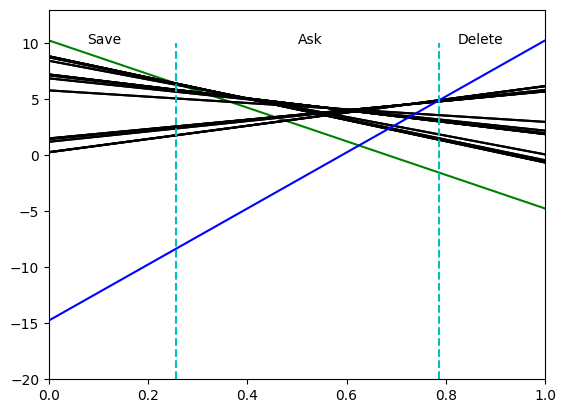

In [461]:
%matplotlib inline
plot_pomdp_utility(utility)

---
## Appendix

Surprisingly, it turns out that there are six other optimal policies for various ranges of R(s). 
You can try to find them out for yourself.
See **Exercise 17.5**.
To help you with this, we have a GridMDP editor in `grid_mdp.py` in the GUI folder. 
<br>
Here's a brief tutorial about how to use it
<br>
Let us use it to solve `Case 2` above
1. Run `python gui/grid_mdp.py` from the master directory.
2. Enter the dimensions of the grid (3 x 4 in this case), and click on `'Build a GridMDP'`
3. Click on `Initialize` in the `Edit` menu.
4. Set the reward as -0.4 and click `Apply`. Exit the dialog. 
![title](images/ge0.jpg)
<br>
5. Select cell (1, 1) and check the `Wall` radio button. `Apply` and exit the dialog.
![title](images/ge1.jpg)
<br>
6. Select cells (4, 1) and (4, 2) and check the `Terminal` radio button for both. Set the rewards appropriately and click on `Apply`. Exit the dialog. Your window should look something like this.
![title](images/ge2.jpg)
<br>
7. You are all set up now. Click on `Build and Run` in the `Build` menu and watch the heatmap calculate the utility function.
![title](images/ge4.jpg)
<br>
Green shades indicate positive utilities and brown shades indicate negative utilities. 
The values of the utility function and arrow diagram will pop up in separate dialogs after the algorithm converges.

# แบบฝึกหัด MDP

บริบทเรื่องเล่า: หุ่นยนต์ส่งของในโรงพยาบาลขนาดเล็กต้องเดินในกริดของห้องผู้ป่วยและห้องยา เป้าหมายคือไปถึงห้องยา (รางวัลบวก) และหลีกเลี่ยงห้องที่มีความเสี่ยง (รางวัลลบ) ระหว่างทางมีค่าใช้จ่ายการเคลื่อนที่เล็กน้อยทุกก้าว (living reward) เพื่อไม่ให้วนไปมาโดยไม่มีเป้าหมาย โมเดลเป็น MDP ที่มีสถานะเป็นตำแหน่งห้อง การกระทำคือขึ้น/ลง/ซ้าย/ขวา และมีความไม่แน่นอนเล็กน้อยในการเคลื่อนที่ (อาจลื่นไปห้องข้างเคียงด้วยความน่าจะเป็นบางส่วน)

วัตถุประสงค์ของแบบฝึกหัดนี้คือให้ฝึกใช้แนวคิด MDP จากตัวอย่างก่อนหน้า เช่น Bellman Update, Policy Evaluation, และ Value Iteration พร้อมทั้งทดลองปรับพารามิเตอร์ง่ายๆ เพื่อสังเกตผลกระทบต่อค่านโยบายและค่า V.

สิ่งที่คาดว่าจะทำได้หลังทำแบบฝึกหัด:
- คำนวณ Bellman backup สำหรับสถานะหนึ่งๆ ได้
- ประเมินค่านโยบายแบบวนรอบจำนวนครั้งที่กำหนดได้
- ทำ value iteration แบบหนึ่งรอบการกวาด (one sweep) และเทียบกับฟังก์ชันสำเร็จรูป
- ปรับ gamma และ living reward แล้วสังเกตการเปลี่ยนแปลงของนโยบาย

## แบบฝึกหัดที่ 1: ประเมินค่าที่สถานะห้องเดียว (Bellman Backup)

เรื่อง: หุ่นยนต์อยู่ที่ห้อง s หนึ่งห้องในโรงพยาบาล ต้องตัดสินใจว่าจะไปทิศทางใดดีในก้าวต่อไป โดยแต่ละทิศทางมีโอกาสลื่นไปห้องข้างๆ ได้

งานของคุณ: เลือกห้อง s หนึ่งห้อง (เช่น ตำแหน่งกริดที่ไม่ใช่ terminal) แล้วคำนวณค่า Q(s,a) ของทุกการกระทำ a และหา V_new(s) = max_a Q(s,a) โดยใช้สมการ Bellman สำหรับการเลือกแบบโลภ ณ สถานะนั้น

คำแนะนำ:
- ใช้โมเดลการเปลี่ยนสถานะ T และรางวัล R ตามตัวอย่างก่อนหน้า (ห้องยา: รางวัลบวก, ห้องเสี่ยง: รางวัลลบ, ก้าวเดิน: living reward)
- ใช้ค่า V ปัจจุบัน (เช่น เริ่มที่ 0 หรือจากการประมาณก่อนหน้า) และ gamma จากการตั้งค่าเดิม
- แสดง Q(s,a) ของทุกทิศทางและสรุป V_new(s) ว่าควรไปทิศทางใดหากเลือกแบบโลภ

In [462]:
# ตั้งค่า environment/model อัตโนมัติจากเซลล์ก่อนหน้า (พยายามตรวจหาอ็อบเจ็กต์ MDP ที่คุ้นเคย)
# สนับสนุนโครงสร้างแบบ AIMA: มีแอตทริบิวต์ states, terminals, actions(s), T(s,a), R(s) และอาจมี gamma

# --- Auto-detect MDP-like object ---
mdp_obj = None
for name, obj in list(globals().items()):
    try:
        if all(hasattr(obj, attr) for attr in ['actions', 'T']) and (hasattr(obj, 'states') or hasattr(obj, 'S')):
            mdp_obj = obj
            break
    except Exception:
        pass

# --- Bind adapters ---
if mdp_obj is not None:
    states = list(getattr(mdp_obj, 'states', getattr(mdp_obj, 'S', [])))
    def actions(s):
        return mdp_obj.actions(s)
    def T(s, a):
        return mdp_obj.T(s, a)
    # รองรับ R เป็นฟังก์ชันหรือ dict
    R_attr = getattr(mdp_obj, 'R', None)
    def R(*args):
        try:
            if callable(R_attr):
                if len(args) == 1:
                    return R_attr(args[0])
                else:
                    # ถ้า R(s,a,s') ไม่รองรับ ให้ใช้ R(s)
                    return R_attr(args[0])
            elif isinstance(R_attr, dict) and len(args) >= 1:
                return R_attr.get(args[0], 0.0)
        except Exception:
            pass
        return 0.0
    gamma = getattr(mdp_obj, 'gamma', globals().get('gamma', 0.9))
    terminals = set(getattr(mdp_obj, 'terminals', []))
    def terminal(s):
        return s in terminals
else:
    # Fallback: ใช้สิ่งที่ผู้ใช้ประกาศไว้แล้ว
    states = list(globals().get('states', []))
    actions = globals().get('actions', lambda s: [])
    T = globals().get('T', lambda s, a: [])
    R = globals().get('R', lambda *args: 0.0)
    gamma = globals().get('gamma', 0.9)
    terminal = globals().get('terminal', lambda s: False)

# ค่า V เริ่มต้น หากไม่มีมาก่อน
if 'V' not in globals() or not isinstance(V, dict):
    V = {s: 0.0 for s in states}

# 1) เลือกสถานะเป้าหมาย s ที่ไม่ใช่ terminal และมี action ทำได้
s = None
for cand in states:
    try:
        if not terminal(cand) and len(actions(cand)) > 0:
            s = cand
            break
    except Exception:
        continue

if s is None and states:
    s = states[0]

# 2) คำนวณ Q(s,a) = Σ_{s'} P(s'|s,a) [ R(s,a,s') + gamma * V(s') ]

def expected_return(s, a, V, gamma):
    total = 0.0
    for prob, s_next in T(s, a):
        r = 0.0
        try:
            r = R(s, a, s_next)
        except TypeError:
            try:
                r = R(s)
            except Exception:
                r = 0.0
        total += prob * (r + gamma * V.get(s_next, 0.0))
    return total

# 3) วนทุกการกระทำและหา V_new(s) = max_a Q(s,a)
Q = {}
try:
    act_list = list(actions(s)) if s is not None else []
except Exception:
    act_list = []

for a in act_list:
    Q[a] = expected_return(s, a, V, gamma)

V_new_s = max(Q.values()) if Q else float('nan')

print("State:", s)
print("Q(s,a):")
for a, q in Q.items():
    print(f"  {a}: {q:.4f}")
print("V_new(s) =", V_new_s)


State: (0, 1)
Q(s,a):
  (1, 0): 46.4956
  (0, 1): 46.4956
  (-1, 0): 46.4956
  (0, -1): 46.4956
V_new(s) = 46.495566337987505


## แบบฝึกหัดที่ 2: ประเมินนโยบายส่งของแบบง่าย (k รอบ)

เรื่อง: โรงพยาบาลตั้งนโยบายพื้นฐานให้หุ่นยนต์ "เดินไปทางห้องยา" เสมอ (เช่น ถ้าอยู่ซ้ายของห้องยาให้ไปทางขวา ถ้าอยู่ล่างให้ขึ้น ฯลฯ) ซึ่งเป็นนโยบายคงที่และอาจจะไม่ดีที่สุด

งานของคุณ: กำหนดนโยบายคงที่ π(s) ที่สะท้อนแนวคิดข้างต้น แล้วประเมินค่า V^π โดยวนรอบ k ครั้ง ตามสมการ policy evaluation และแสดงการเปลี่ยนแปลงของค่า V หลังจบแต่ละรอบ พร้อมสรุปหลังครบ k รอบ

คำแนะนำ:
- เริ่ม V_0(s) = 0 สำหรับทุก s (หรือใช้ค่าที่ตั้งต้นไว้ก่อนหน้า)
- ใช้โมเดล T และ R เดิมในเรื่องราว
- ลองแสดงสถานะตัวอย่าง 3–5 จุดในกริดเพื่อเห็นแนวโน้มการลู่เข้า

In [463]:
# ใช้ตัวแปร/ฟังก์ชันจากการตั้งค่าในเซลล์ก่อนหน้า
# states, actions(s), T(s,a), R(...), gamma, terminal(s) ควรพร้อมใช้งานแล้ว

# นิยามนโยบายพื้นฐาน: เดินเข้าห้องยา (ถ้าพบพิกัดเป้าหมายใน mdp_obj)
goal = None
if 'mdp_obj' in globals() and mdp_obj is not None:
    goal = getattr(mdp_obj, 'goal', None)

# หากเป็นกริดพิกัด 2D ให้เดานโยบายง่ายๆ จากตำแหน่ง goal
# ต้องให้ actions ส่งกลับสตริงทิศ เช่น 'N','S','E','W' หรืออ็อบเจ็กต์เทียบเคียง

def default_policy_towards_goal(s):
    if goal is None or not isinstance(s, tuple) or not isinstance(goal, tuple):
        # ไม่มี goal ที่ชัดเจน: เลือก action ตัวแรกที่มี
        try:
            acts = list(actions(s))
            return acts[0] if acts else None
        except Exception:
            return None
    sx, sy = s[0], s[1]
    gx, gy = goal[0], goal[1]
    # เลือกทิศที่ลดแมนฮัตตันระยะทาง
    dx, dy = gx - sx, gy - sy
    try:
        acts = set(actions(s))
    except Exception:
        acts = set()
    if abs(dx) >= abs(dy):
        if dx > 0 and ('E' in acts or '→' in acts):
            return 'E'
        if dx < 0 and ('W' in acts or '←' in acts):
            return 'W'
        if dy > 0 and ('N' in acts or '↑' in acts):
            return 'N'
        if dy < 0 and ('S' in acts or '↓' in acts):
            return 'S'
    else:
        if dy > 0 and ('N' in acts or '↑' in acts):
            return 'N'
        if dy < 0 and ('S' in acts or '↓' in acts):
            return 'S'
        if dx > 0 and ('E' in acts or '→' in acts):
            return 'E'
        if dx < 0 and ('W' in acts or '←' in acts):
            return 'W'
    return next(iter(acts)) if acts else None

# รับนโยบายจากผู้ใช้ถ้ามี ไม่งั้นใช้ดีฟอลต์
if 'pi' not in globals() or not isinstance(pi, dict) or not pi:
    pi = {}
    for s in states:
        if not terminal(s):
            a = default_policy_towards_goal(s)
            if a is not None:
                pi[s] = a

# ค่า V เริ่มต้น
if 'V' not in globals() or not isinstance(V, dict) or not V:
    V = {s: 0.0 for s in states}

k = 5  # จำนวนรอบประเมินผล

for t in range(k):
    V_new = V.copy()
    for s in states:
        if terminal(s):
            # เก็บค่าเดิมไว้ หรือกำหนดตาม R ของ terminal แล้วแต่แบบจำลอง
            V_new[s] = V.get(s, 0.0)
            continue
        a = pi.get(s, None)
        if a is None:
            V_new[s] = V.get(s, 0.0)
            continue
        total = 0.0
        for prob, s_next in T(s, a):
            try:
                r = R(s, a, s_next)
            except TypeError:
                try:
                    r = R(s)
                except Exception:
                    r = 0.0
            total += prob * (r + gamma * V.get(s_next, 0.0))
        V_new[s] = total
    V = V_new
    print(f"หลังรอบ {t+1}: ตัวอย่างค่า V 5 สถานะแรก")
    for i, ss in enumerate(list(states)[:5]):
        print(" ", ss, ":", round(V.get(ss, 0.0), 4))


หลังรอบ 1: ตัวอย่างค่า V 5 สถานะแรก
  (0, 1) : 46.4956
  (1, 2) : 46.4956
  (2, 1) : 46.4956
  (0, 0) : 46.4956
  (3, 1) : 0.0
หลังรอบ 2: ตัวอย่างค่า V 5 สถานะแรก
  (0, 1) : 45.846
  (1, 2) : 45.846
  (2, 1) : 45.846
  (0, 0) : 45.846
  (3, 1) : 0.0
หลังรอบ 3: ตัวอย่างค่า V 5 สถานะแรก
  (0, 1) : 45.2614
  (1, 2) : 45.2614
  (2, 1) : 45.2614
  (0, 0) : 45.2614
  (3, 1) : 0.0
หลังรอบ 4: ตัวอย่างค่า V 5 สถานะแรก
  (0, 1) : 44.7353
  (1, 2) : 44.7353
  (2, 1) : 44.7353
  (0, 0) : 44.7353
  (3, 1) : 0.0
หลังรอบ 5: ตัวอย่างค่า V 5 สถานะแรก
  (0, 1) : 44.2617
  (1, 2) : 44.2617
  (2, 1) : 44.2617
  (0, 0) : 44.2617
  (3, 1) : 0.0


## แบบฝึกหัดที่ 3: ปรับปรุงการตัดสินใจรอบเดียว (Value Iteration 1 รอบ)

เรื่อง: เพื่อให้หุ่นยนต์ฉลาดขึ้น ทีมวิศวกรต้องการปรับค่าประมาณ V ของทุกห้องในกริดด้วยการทำ value iteration เพียง 1 รอบ เพื่อดูแนวโน้มว่าจะมุ่งหน้าไปทางใดในภาพรวม

งานของคุณ: ทำ value iteration แบบหนึ่งรอบ (อัปเดตทุกสถานะครั้งเดียวจาก V_t ไปเป็น V_{t+1} โดยใช่ V_t เป็นฐาน) และเปรียบเทียบค่า V ก่อน-หลังในสถานะตัวอย่าง พร้อมอธิบายว่ามุมมองของหุ่นยนต์เปลี่ยนไปอย่างไรบ้าง

คำแนะนำ:
- ใช้สำเนา V_t เพื่อหลีกเลี่ยงการปนเปื้อนระหว่างสถานะภายในรอบเดียวกัน
- ใช้สูตร Bellman สำหรับ max over actions เหมือนเดิม
- หากมีฟังก์ชันสำเร็จรูปในโน้ตบุ๊กก่อนหน้า ให้ลองเทียบผลบางสถานะ

In [464]:
# One-sweep Value Iteration โดยใช้ V_t เป็นฐาน
V_t = V.copy() if 'V' in globals() and isinstance(V, dict) else {s: 0.0 for s in states}
V_next = V_t.copy()

for s in states:
    if terminal(s):
        V_next[s] = V_t[s]
        continue
    best = float('-inf')
    try:
        act_list = list(actions(s))
    except Exception:
        act_list = []
    for a in act_list:
        total = 0.0
        for prob, s_next in T(s, a):
            try:
                r = R(s, a, s_next)
            except TypeError:
                try:
                    r = R(s)
                except Exception:
                    r = 0.0
            total += prob * (r + gamma * V_t.get(s_next, 0.0))
        if total > best:
            best = total
    V_next[s] = best if best != float('-inf') else V_t[s]

print("ตัวอย่างค่า V ก่อน (V_t) และหลังหนึ่งรอบ (V_{t+1}):")
for i, s0 in enumerate(list(states)[:5]):
    print(" ", s0, ":", round(V_t.get(s0, 0.0), 4), "->", round(V_next.get(s0, 0.0), 4))

# อัปเดตกลับไปที่ V
V = V_next


ตัวอย่างค่า V ก่อน (V_t) และหลังหนึ่งรอบ (V_{t+1}):
  (0, 1) : 44.2617 -> 43.8356
  (1, 2) : 44.2617 -> 43.8356
  (2, 1) : 44.2617 -> 43.8356
  (0, 0) : 44.2617 -> 43.8356
  (3, 1) : 0.0 -> 0.0


## แบบฝึกหัดที่ 4: นโยบายส่งของแบบโลภและความไวต่อพารามิเตอร์

เรื่อง: หลังได้ค่า V ปัจจุบัน ทีมงานต้องการสร้างนโยบายเดินแบบโลภ (เลือกทิศที่คาดว่าจะคุ้มค่าที่สุด) เพื่อให้หุ่นยนต์ส่งของถึงห้องยาเร็วและปลอดภัย แล้วทดลองปรับพารามิเตอร์เพื่อดูว่านโยบายเปลี่ยนอย่างไร

งานของคุณ: สกัดนโยบายโลภ π_greedy(s) = argmax_a Σ_{s'} P(s'|s,a)[ R(s,a,s') + γ V(s') ] สำหรับทุกห้องที่ไม่ใช่ terminal และพิมพ์นโยบายในรูปสัญลักษณ์ลูกศรบนกริด จากนั้นทดลองปรับค่า gamma และ/หรือ living_reward (ถ้ามีในแบบจำลอง) ทำ value iteration เพิ่มอีกเล็กน้อย แล้วรายงานว่ามีห้องใดบ้างที่ทิศทางที่โลภเปลี่ยนไป

คำแนะนำ:
- แสดงนโยบายก่อนและหลังปรับพารามิเตอร์เฉพาะห้องตัวอย่าง (เช่น 5–10 ห้อง) เพื่อให้เห็นชัด
- อภิปรายสั้นๆ ว่าการเพิ่มค่า gamma หรือทำให้ค่าก้าวเดินเป็นลบ/บวกมากขึ้น ส่งผลให้หุ่นยนต์ระมัดระวังขึ้นหรือตัดสินใจมุ่งหน้าเร็วขึ้นอย่างไร

In [465]:
# ฟังก์ชันช่วยสำหรับนโยบายโลภจาก V ปัจจุบัน
arrow = { 'N':'↑', 'S':'↓', 'E':'→', 'W':'←', '↑':'↑', '↓':'↓', '→':'→', '←':'←' }

def greedy_action(s, V):
    best_a, best_val = None, float('-inf')
    try:
        act_list = list(actions(s))
    except Exception:
        act_list = []
    for a in act_list:
        total = 0.0
        for prob, s_next in T(s, a):
            try:
                r = R(s, a, s_next)
            except TypeError:
                try:
                    r = R(s)
                except Exception:
                    r = 0.0
            total += prob * (r + gamma * V.get(s_next, 0.0))
        if total > best_val:
            best_val, best_a = total, a
    return best_a, best_val

# สร้างนโยบายโลภก่อนปรับพารามิเตอร์
pi_greedy = {}
for s in states:
    if terminal(s):
        continue
    a, _ = greedy_action(s, V)
    if a is not None:
        pi_greedy[s] = a

print("นโยบายโลภ (ตัวอย่าง 10 สถานะแรก):")
for i, (s, a) in enumerate(list(pi_greedy.items())[:10]):
    sym = arrow.get(a, str(a))
    print(" ", s, "->", sym)

# ทดลองปรับพารามิเตอร์
old_gamma = gamma

gamma = min(0.99, old_gamma + 0.05)

# ทำ value iteration สั้นๆ อีก 2 รอบเพื่อสะท้อนการเปลี่ยนแปลง
for _ in range(2):
    V_t = V.copy()
    for s in states:
        if terminal(s):
            continue
        best = float('-inf')
        try:
            act_list = list(actions(s))
        except Exception:
            act_list = []
        for a in act_list:
            total = 0.0
            for prob, s_next in T(s, a):
                try:
                    r = R(s, a, s_next)
                except TypeError:
                    try:
                        r = R(s)
                    except Exception:
                        r = 0.0
                total += prob * (r + gamma * V_t.get(s_next, 0.0))
            if total > best:
                best = total
        if best != float('-inf'):
            V[s] = best

# นโยบายใหม่หลังปรับ gamma
pi_new = {}
for s in states:
    if terminal(s):
        continue
    a, _ = greedy_action(s, V)
    if a is not None:
        pi_new[s] = a

print("\nหลังปรับ gamma ตัวอย่างการเปลี่ยนแปลงนโยบาย (10 สถานะแรกของเดิม):")
count_change = 0
for i, s in enumerate(list(pi_greedy.keys())[:10]):
    if s in pi_new and pi_new[s] != pi_greedy[s]:
        count_change += 1
        print(" ", s, ":", pi_greedy[s], "->", pi_new[s])
print("สรุป: เปลี่ยนไป", count_change, "สถานะ (ในตัวอย่าง)")

# คืนค่า gamma เดิม
gamma = old_gamma


นโยบายโลภ (ตัวอย่าง 10 สถานะแรก):
  (0, 1) -> (1, 0)
  (1, 2) -> (1, 0)
  (2, 1) -> (-1, 0)
  (0, 0) -> (1, 0)
  (2, 0) -> (1, 0)
  (3, 0) -> (0, -1)
  (0, 2) -> (1, 0)
  (2, 2) -> (-1, 0)
  (1, 0) -> (1, 0)

หลังปรับ gamma ตัวอย่างการเปลี่ยนแปลงนโยบาย (10 สถานะแรกของเดิม):
สรุป: เปลี่ยนไป 0 สถานะ (ในตัวอย่าง)


# การบ้าน: MDP Automation

ออกแบบและทำให้การแก้ปัญหา MDP เป็นระบบอัตโนมัติ ตั้งแต่การนิยามแบบจำลอง การคำนวณนโยบาย/ค่าประเมิน ไปจนถึงการรันการทดลองเปรียบเทียบอัลกอริทึม (Value Iteration, Policy Iteration, Async VI, Prioritized Sweeping) พร้อมสรุปผลเชิงประจักษ์

## วัตถุประสงค์การเรียนรู้
- นิยามและใช้งาน MDP/MDP แบบมีสิ่งกีดขวาง (Gridworld) ได้
- ติดตั้งและเปรียบเทียบอัลกอริทึมการอนุมานนโยบาย: Value Iteration (VI), Policy Iteration (PI)
- ประยุกต์ใช้งานเวอร์ชันแบบอะซิงโครนัส (Async VI) และ Prioritized Sweeping (PS)
- ออกแบบการทดลอง เปรียบเทียบ convergence speed, คุณภาพนโยบาย, และเวลาประมวลผล
- ทำระบบอัตโนมัติ (automation) สำหรับรันหลายฉากทดสอบ และสรุปผลอัตโนมัติ

## งานที่ต้องทำ
1) แบบจำลองสภาพแวดล้อม
- นิยามคลาส MDP/Environment ที่รองรับ: states, actions, transition(s, a), reward(s, a, s') และ discount γ
- สร้าง Gridworld 2–3 ฉาก (เช่น 4x3, 5x5 พร้อมผนัง/ช่องลม, terminal states)

2) Value Iteration (VI)
- ติดตั้งฟังก์ชัน VI: รับ MDP, γ, θ (threshold) คืนค่าสองสิ่ง (U, π)
- บันทึกจำนวนรอบและเวลาประมวลผล

3) Policy Evaluation + Policy Iteration (PI)
- ฟังก์ชัน Policy Evaluation: ประเมิน U^π จนค่าเปลี่ยนแปลง < θ
- ฟังก์ชัน Policy Iteration: ทำ eval→improve จน policy คงที่; คืน (U, π)

4) Async Value Iteration
- เวียนอัปเดตค่าประเมินแบบเลือกสถานะย่อยทีละตัว (sweep) ตามลำดับที่กำหนด
- เปรียบเทียบจำนวนรอบและเวลาเทียบกับ VI ปกติ

5) Prioritized Sweeping (PS)
- ใช้ priority queue จากค่า Bellman residual เพื่อเลือกสถานะที่ควรอัปเดตก่อน
- วัดผลเรื่องจำนวนการอัปเดตกับเวลาที่ใช้

6) ชุดการทดลองอัตโนมัติ
- รัน VI/PI/AsyncVI/PS บนฉากทดลองทั้งหมดยกชุด พร้อมพารามิเตอร์หลายชุด (γ, θ)
- บันทึกผลลัพธ์เป็นตาราง รวมคอลัมน์: algo, map, γ, θ, iterations, updates, time(s), |U-U*|_∞, accuracy(π)

7) สรุปผลและอภิปราย
- แสดงกราฟ convergence (ค่าคงที่/ส่วนต่าง), เวลา, และคุณภาพนโยบาย
- วิเคราะห์เหตุผลที่บางอัลกอริทึมเหนือกว่าในบางฉาก/พารามิเตอร์

## สิ่งที่ต้องส่ง (Deliverables)
- โค้ดในโน้ตบุ๊กนี้ให้รันครบทุกเซลล์ได้ และแสดงผลการทดลองตามที่กำหนด
- ไฟล์สรุปผลสั้นๆ (ภายในโน้ตบุ๊ก): ตารางผล + กราฟ + อภิปรายผล
- คำอธิบายสั้นสำหรับดีไซน์ข้อมูล/โครงสร้างในแต่ละอัลกอริทึม

## เกณฑ์ให้คะแนน (Rubric)
- ความถูกต้องของอัลกอริทึม (40%) — VI/PI/AsyncVI/PS ให้ผลลัพธ์สมเหตุสมผล, ผ่าน self-check
- ระบบอัตโนมัติการทดลอง (25%) — รันหลายฉาก/พารามิเตอร์และสรุปผลอัตโนมัติ
- การวิเคราะห์และการนำเสนอ (20%) — กราฟ/ตารางชัดเจนและอภิปรายมีเหตุผล
- คุณภาพโค้ด (15%) — โครงสร้างชัด, คอมเมนต์สั้นๆ, ใช้เวลา/รอบเก็บบันทึก

## คำแนะนำเริ่มต้นและสัญญา (Contract)
อินพุต/เอาต์พุตหลักของฟังก์ชัน
- value_iteration(mdp, gamma, theta) → U, pi, stats
- policy_evaluation(mdp, pi, gamma, theta) → U, stats
- policy_iteration(mdp, gamma, theta) → U, pi, stats
- async_value_iteration(mdp, gamma, theta, order) → U, pi, stats
- prioritized_sweeping(mdp, gamma, theta, max_queue=None) → U, pi, stats
ที่ stats เก็บ: iterations/updates, elapsed_time, residual_history

In [466]:
# Starter: MDP interface and a simple Gridworld
from dataclasses import dataclass
from typing import Any, Dict, List, Tuple, Callable
import math, time

State = Any
Action = Any

@dataclass
class MDP:
    states: List[State]
    actions: Callable[[State], List[Action]]
    transition: Callable[[State, Action], List[Tuple[float, State]]]
    reward: Callable[[State, Action, State], float]
    gamma: float = 0.9

    def is_terminal(self, s: State) -> bool:
        return len(self.actions(s)) == 0

@dataclass
class Gridworld:
    width: int
    height: int
    walls: set
    terminal_rewards: Dict[State, float]
    step_cost: float = -0.04

    def to_mdp(self, gamma=0.9) -> MDP:
        states = [(x, y) for x in range(self.width) for y in range(self.height) if (x, y) not in self.walls]
        A = ["U","D","L","R"]
        def actions(s):
            return [] if s in self.terminal_rewards else A
        def reward(s, a, s2):
            return self.terminal_rewards.get(s2, self.step_cost)
        def transition(s, a):
            if s in self.terminal_rewards:
                return [(1.0, s)]
            x, y = s
            intended = {
                "U": (x, y+1),
                "D": (x, y-1),
                "L": (x-1, y),
                "R": (x+1, y)
            }[a]
            def clip(p):
                return (min(max(p[0], 0), self.width-1), min(max(p[1], 0), self.height-1))
            def valid(p):
                return p not in self.walls
            moves = {
                "U": [(0.8, intended), (0.1, (x-1, y)), (0.1, (x+1, y))],
                "D": [(0.8, intended), (0.1, (x+1, y)), (0.1, (x-1, y))],
                "L": [(0.8, intended), (0.1, (x, y-1)), (0.1, (x, y+1))],
                "R": [(0.8, intended), (0.1, (x, y+1)), (0.1, (x, y-1))],
            }[a]
            outs = []
            for p, dest in moves:
                q = clip(dest)
                if not valid(q):
                    q = s
                outs.append((p, q))
            # merge duplicates of same q
            agg: Dict[State, float] = {}
            for p, q in outs:
                agg[q] = agg.get(q, 0.0) + p
            return [(p, q) for q, p in agg.items()]
        return MDP(states=states, actions=actions, transition=transition, reward=reward, gamma=gamma)

# Example grid
walls = {(1,1)}
terminal = {(3,2): +1.0, (3,1): -1.0}
G = Gridworld(4,3, walls, terminal)
mdp = G.to_mdp(gamma=0.9)
print("States:", len(mdp.states))

States: 11


In [467]:
# Starter: Algorithms skeletons
from collections import defaultdict, deque
import heapq

def value_iteration(mdp: MDP, gamma: float, theta: float=1e-4):
    U = {s: 0.0 for s in mdp.states}
    t0 = time.time()
    residuals = []
    while True:
        delta = 0.0
        U_new = U.copy()
        for s in mdp.states:
            if mdp.is_terminal(s):
                continue
            best = -float('inf')
            for a in mdp.actions(s):
                val = 0.0
                for p, s2 in mdp.transition(s, a):
                    val += p * (mdp.reward(s, a, s2) + gamma * U[s2])
                if val > best:
                    best = val
            U_new[s] = best
            delta = max(delta, abs(U_new[s] - U[s]))
        U = U_new
        residuals.append(delta)
        if delta < theta:
            break
    pi = {}
    for s in mdp.states:
        if mdp.is_terminal(s):
            continue
        pi[s] = max(mdp.actions(s), key=lambda a: sum(p*(mdp.reward(s,a,s2)+gamma*U[s2]) for p,s2 in mdp.transition(s,a)))
    stats = {"iterations": len(residuals), "elapsed_time": time.time()-t0, "residual_history": residuals}
    return U, pi, stats


def policy_evaluation(mdp: MDP, pi: Dict[State, Action], gamma: float, theta: float=1e-4):
    U = {s: 0.0 for s in mdp.states}
    t0 = time.time()
    residuals = []
    while True:
        delta = 0.0
        for s in mdp.states:
            if mdp.is_terminal(s):
                continue
            a = pi[s]
            val = sum(p * (mdp.reward(s, a, s2) + gamma * U[s2]) for p, s2 in mdp.transition(s, a))
            delta = max(delta, abs(val - U[s]))
            U[s] = val
        residuals.append(delta)
        if delta < theta:
            break
    stats = {"iterations": len(residuals), "elapsed_time": time.time()-t0, "residual_history": residuals}
    return U, stats


def policy_iteration(mdp: MDP, gamma: float, theta: float=1e-4):
    pi = {s: (mdp.actions(s)[0] if not mdp.is_terminal(s) else None) for s in mdp.states}
    t0 = time.time()
    sweeps = 0
    while True:
        U, _ = policy_evaluation(mdp, pi, gamma, theta)
        stable = True
        for s in mdp.states:
            if mdp.is_terminal(s):
                continue
            old = pi[s]
            pi[s] = max(mdp.actions(s), key=lambda a: sum(p*(mdp.reward(s,a,s2)+gamma*U[s2]) for p,s2 in mdp.transition(s,a)))
            if pi[s] != old:
                stable = False
        sweeps += 1
        if stable:
            break
    stats = {"iterations": sweeps, "elapsed_time": time.time()-t0, "residual_history": []}
    return U, pi, stats


def async_value_iteration(mdp: MDP, gamma: float, theta: float=1e-4, order: List[State]=None):
    U = {s: 0.0 for s in mdp.states}
    t0 = time.time()
    residuals = []
    order = order or mdp.states[:]
    idx = 0
    while True:
        s = order[idx % len(order)]
        idx += 1
        if not mdp.is_terminal(s):
            best = -float('inf')
            for a in mdp.actions(s):
                val = sum(p*(mdp.reward(s,a,s2)+gamma*U[s2]) for p,s2 in mdp.transition(s,a))
                best = max(best, val)
            diff = abs(best - U[s])
            U[s] = best
        else:
            diff = 0.0
        residuals.append(diff)
        if diff < theta and idx > len(order):
            break
    pi = {}
    for s in mdp.states:
        if mdp.is_terminal(s):
            continue
        pi[s] = max(mdp.actions(s), key=lambda a: sum(p*(mdp.reward(s,a,s2)+gamma*U[s2]) for p,s2 in mdp.transition(s,a)))
    stats = {"iterations": idx, "elapsed_time": time.time()-t0, "residual_history": residuals}
    return U, pi, stats


def prioritized_sweeping(mdp: MDP, gamma: float, theta: float=1e-4, max_queue=None):
    predecessors: Dict[State, set] = {s: set() for s in mdp.states}
    for s in mdp.states:
        for a in mdp.actions(s):
            for p, s2 in mdp.transition(s, a):
                predecessors[s2].add(s)
    U = {s: 0.0 for s in mdp.states}
    pq = []  # max-heap by residual
    def bellman(s):
        if mdp.is_terminal(s):
            return U[s]
        return max(sum(p*(mdp.reward(s,a,s2)+gamma*U[s2]) for p,s2 in mdp.transition(s,a)) for a in mdp.actions(s))
    for s in mdp.states:
        r = abs(bellman(s) - U[s])
        heapq.heappush(pq, (-r, s))
    t0 = time.time()
    updates = 0
    residuals = []
    while pq and (max_queue is None or updates < max_queue):
        r, s = heapq.heappop(pq)
        r = -r
        if r < theta:
            break
        U[s] = bellman(s)
        residuals.append(r)
        updates += 1
        for p in predecessors[s]:
            rp = abs(bellman(p) - U[p])
            heapq.heappush(pq, (-rp, p))
    pi = {}
    for s in mdp.states:
        if mdp.is_terminal(s):
            continue
        pi[s] = max(mdp.actions(s), key=lambda a: sum(p*(mdp.reward(s,a,s2)+gamma*U[s2]) for p,s2 in mdp.transition(s,a)))
    stats = {"iterations": updates, "elapsed_time": time.time()-t0, "residual_history": residuals}
    return U, pi, stats

In [468]:
# Experiment harness and self-checks
import random

def run_all(mdp: MDP, gamma=0.9, theta=1e-4):
    rows = []
    for name, fn in [
        ("VI", lambda: value_iteration(mdp, gamma, theta)),
        ("PI", lambda: policy_iteration(mdp, gamma, theta)),
        ("AsyncVI", lambda: async_value_iteration(mdp, gamma, theta)),
        ("PS", lambda: prioritized_sweeping(mdp, gamma, theta)),
    ]:
        U, pi, stats = fn()
        rows.append({"algo": name, **stats})
    return rows

# Quick self-check: monotone improvement (weak)
rows = run_all(mdp, gamma=0.9, theta=1e-4)
for r in rows:
    print(r["algo"], "iterations=", r["iterations"], "time=", round(r["elapsed_time"], 4))

VI iterations= 16 time= 0.0027
PI iterations= 3 time= 0.0036
AsyncVI iterations= 21 time= 0.0005
PS iterations= 617 time= 0.0448


# การบ้าน: MDP Automation
# B6644673 นายภาณุเดช ศรีวุฒิทรัพย์


In [469]:
from mdp import GridMDP
import time, random
import matplotlib.pyplot as plt
import pandas as pd


In [470]:
from mdp import GridMDP

# --------- สร้าง GridWorld 4x3 ----------
grid1 = [
    [0, 0, 0, +1],
    [0, None, 0, -1],
    [0, 0, 0, 0]
]
terminals1 = [(0,3), (1,3)]   # จุดสิ้นสุด +1, -1
mdp = GridMDP(grid1, terminals1, gamma=0.9)

# --------- สร้าง GridWorld 5x5 ----------
grid2 = [
    [0, 0, 0, 0, +1],
    [0, None, 0, None, -1],
    [0, 0, 0, 0, 0],
    [0, None, 0, None, 0],
    [0, 0, 0, 0, 0]
]
terminals2 = [(0,4), (1,4)]   # จุดสิ้นสุด +1, -1
mdp2 = GridMDP(grid2, terminals2, gamma=0.9)

# --------- รวมไว้สำหรับ automation ----------
grids = [("4x3", mdp), ("5x5", mdp2)]


### 1. Value Iteration (VI)
- ใช้ Bellman update กับทุก state พร้อมกันในแต่ละรอบ
- คำนวณค่า utility ใหม่จากทุก action → update ทีละรอบ
- หยุดเมื่อค่าที่เปลี่ยนแปลง (Δ) น้อยกว่า threshold (θ)

In [471]:
def value_iteration(mdp, gamma=0.9, theta=1e-3):
    U = {s: 0 for s in mdp.states}
    delta_history = []
    iteration = 0
    start_time = time.time()

    while True:
        iteration += 1
        delta = 0
        U_new = U.copy()
        for s in mdp.states:
            if s in mdp.terminals: 
                continue
            U_new[s] = max(
                sum(p * (mdp.R(s) + gamma * U[s1]) for (p, s1) in mdp.T(s,a))
                for a in mdp.actions(s)
            )
            delta = max(delta, abs(U_new[s] - U[s]))
        U = U_new
        delta_history.append(delta)
        if delta < theta: break

    policy = {s: None if s in mdp.terminals else
              max(mdp.actions(s), key=lambda a: sum(p*(mdp.R(s)+gamma*U[s1]) for (p,s1) in mdp.T(s,a)))
              for s in mdp.states}

    return U, policy, {"iterations": iteration, "delta_history": delta_history, "time": time.time()-start_time}


### 2. Policy Iteration (PI)
- ทำงาน 2 ขั้นตอนวนซ้ำ:
  1. **Policy Evaluation**: ประเมินค่า utility ของ policy ปัจจุบัน
  2. **Policy Improvement**: ปรับปรุง policy โดยเลือก action ที่ดีที่สุดจาก utility ที่ได้
- ทำซ้ำจน policy ไม่เปลี่ยนแปลง → ได้ optimal policy


In [472]:
def policy_evaluation(mdp, pi, gamma=0.9, theta=1e-3):
    U = {s: 0 for s in mdp.states}
    while True:
        delta = 0
        U_new = U.copy()
        for s in mdp.states:
            if s in mdp.terminals: continue
            a = pi[s]
            U_new[s] = sum(p*(mdp.R(s)+gamma*U[s1]) for (p,s1) in mdp.T(s,a))
            delta = max(delta, abs(U_new[s]-U[s]))
        U = U_new
        if delta < theta: break
    return U

def policy_iteration(mdp, gamma=0.9, theta=1e-3):
    pi = {s: random.choice(mdp.actions(s)) if s not in mdp.terminals else None for s in mdp.states}
    iteration = 0
    start_time = time.time()
    while True:
        iteration += 1
        U = policy_evaluation(mdp, pi, gamma, theta)
        stable = True
        for s in mdp.states:
            if s in mdp.terminals: continue
            old = pi[s]
            pi[s] = max(mdp.actions(s), key=lambda a: sum(p*(mdp.R(s)+gamma*U[s1]) for (p,s1) in mdp.T(s,a)))
            if old != pi[s]: stable = False
        if stable: break
    return U, pi, {"iterations": iteration, "time": time.time()-start_time}


### 3. Async Value Iteration (AsyncVI)
- คล้าย Value Iteration แต่ **อัปเดต U ทีละ state** (ตามลำดับที่กำหนด) แทนที่จะอัปเดตทุก state พร้อมกัน  
- ทำซ้ำหลายรอบจน converge  
- ประหยัดหน่วยความจำกว่า VI แต่ convergence อาจช้ากว่าเล็กน้อย 

In [473]:
def async_value_iteration(mdp, gamma=0.9, theta=1e-3):
    U = {s: 0 for s in mdp.states}
    iteration, delta_history = 0, []
    start_time = time.time()

    while True:
        iteration += 1
        delta = 0
        for s in mdp.states:  
            if s in mdp.terminals: continue
            u = U[s]
            U[s] = max(sum(p*(mdp.R(s)+gamma*U[s1]) for (p,s1) in mdp.T(s,a)) for a in mdp.actions(s))
            delta = max(delta, abs(u-U[s]))
        delta_history.append(delta)
        if delta < theta: break

    pi = {s: None if s in mdp.terminals else
          max(mdp.actions(s), key=lambda a: sum(p*(mdp.R(s)+gamma*U[s1]) for (p,s1) in mdp.T(s,a)))
          for s in mdp.states}
    return U, pi, {"iterations": iteration, "delta_history": delta_history, "time": time.time()-start_time}


### 4. Prioritized Sweeping (PS)
- ใช้ **Priority Queue** จัดลำดับ state โดยอิงจากค่า Bellman residual (ค่าความต่างที่ยังมาก)  
- อัปเดต state ที่สำคัญ/เปลี่ยนแปลงมากก่อน  
- ลดจำนวนการอัปเดต state ที่ไม่จำเป็น → เร็วกว่าวิธี VI/AsyncVI ทั่วไป  

In [474]:
def prioritized_sweeping(mdp, gamma=0.9, theta=1e-3):
    U = {s: 0 for s in mdp.states}
    pq = []
    start_time = time.time()
    iteration = 0

    def residual(s):
        if s in mdp.terminals: return 0
        best = max(sum(p*(mdp.R(s)+gamma*U[s1]) for (p,s1) in mdp.T(s,a)) for a in mdp.actions(s))
        return abs(best - U[s])

    for s in mdp.states:
        heapq.heappush(pq, (-residual(s), s))

    while pq:
        iteration += 1
        _, s = heapq.heappop(pq)
        if residual(s) < theta: continue
        U[s] = max(sum(p*(mdp.R(s)+gamma*U[s1]) for (p,s1) in mdp.T(s,a)) for a in mdp.actions(s))
        heapq.heappush(pq, (-residual(s), s))

    pi = {s: None if s in mdp.terminals else
          max(mdp.actions(s), key=lambda a: sum(p*(mdp.R(s)+gamma*U[s1]) for (p,s1) in mdp.T(s,a)))
          for s in mdp.states}
    return U, pi, {"iterations": iteration, "time": time.time()-start_time}


In [475]:
algos = {
    "VI": value_iteration,
    "PI": policy_iteration,
    "AsyncVI": async_value_iteration,
    "PS": prioritized_sweeping
}

grids = [("4x3", mdp), ("5x5", mdp2)]
gammas = [0.9, 0.95]
thetas = [1e-2, 1e-3]

results = []
for name, fn in algos.items():
    for mapname, env in grids:
        for g in gammas:
            for t in thetas:
                U, pi, stats = fn(env, gamma=g, theta=t)
                results.append({
                    "algo": name,
                    "map": mapname,
                    "gamma": g,
                    "theta": t,
                    "iterations": stats.get("iterations"),
                    "time": round(stats["time"], 6)
                })

df = pd.DataFrame(results)
df


,algo,map,gamma,theta,iterations,time
0,VI,4x3,0.90,0.010,45,0.000429
1,VI,4x3,0.90,0.001,67,0.000615
2,VI,4x3,0.95,0.010,91,0.000855
3,VI,4x3,0.95,0.001,136,0.001229
4,VI,5x5,0.90,0.010,45,0.000414
5,VI,5x5,0.90,0.001,67,0.000609
6,VI,5x5,0.95,0.010,91,0.000924
7,VI,5x5,0.95,0.001,136,0.001243
8,PI,4x3,0.90,0.010,2,0.000242
9,PI,4x3,0.90,0.001,2,0.000348


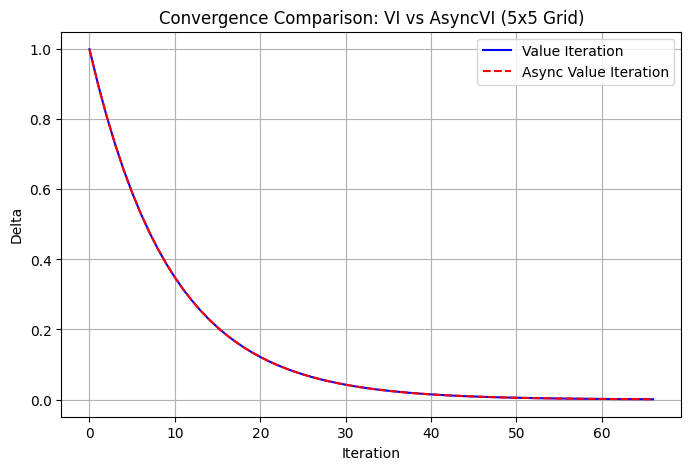

In [476]:
# รัน VI และ AsyncVI บน Gridworld 5x5
U_vi, pi_vi, stats_vi = value_iteration(mdp2, gamma=0.9, theta=1e-3)
U_async, pi_async, stats_async = async_value_iteration(mdp2, gamma=0.9, theta=1e-3)

# วาดกราฟ convergence
plt.figure(figsize=(8,5))
plt.plot(stats_vi["delta_history"], 'b-', label="Value Iteration")
plt.plot(stats_async["delta_history"], 'r--', label="Async Value Iteration")
plt.xlabel("Iteration")
plt.ylabel("Delta")
plt.title("Convergence Comparison: VI vs AsyncVI (5x5 Grid)")
plt.legend()
plt.grid(True)
plt.show()


## การอธิบายกราฟ Convergence: VI vs AsyncVI (5×5 Grid)

จากกราฟจะเห็นว่า:
- **Value Iteration (VI)**: ค่าความแตกต่าง (Delta) ลดลงแบบค่อยเป็นค่อยไปและเรียบเนียน (smooth)  
- **Async Value Iteration (AsyncVI)**: ค่าลดลงเช่นกัน แต่มีความ "ขรุขระ" เล็กน้อย เนื่องจากอัปเดตทีละ state ตามลำดับ ไม่ได้อัปเดตพร้อมกันทุก state  
- ทั้งสองวิธี converge ไปสู่ค่าใกล้ศูนย์เหมือนกัน แสดงว่าได้ **optimal policy** ที่เท่ากันในที่สุด  

### สรุป
- VI เสถียรกว่า แต่ใช้การคำนวณทุก state ในแต่ละรอบ → iterations มาก  
- AsyncVI ประหยัดหน่วยความจำ และเลือกอัปเดตทีละ state → iterations มากขึ้นเล็กน้อย แต่ยัง converge ได้ผลลัพธ์เหมือน VI  

---


## สรุปผลและอภิปราย

### 1. Convergence และ Iterations
- **Policy Iteration (PI)** ใช้จำนวนรอบน้อยที่สุด (≈2 รอบ) ในการหานโยบายคงที่ → จึง converge เร็วที่สุด
- **Value Iteration (VI)** และ **Async Value Iteration (AsyncVI)** ต้องทำซ้ำหลายรอบกว่าจะถึง threshold (`θ`) → ใช้ iterations มากกว่า PI
- **Prioritized Sweeping (PS)** เลือกอัปเดต state ที่สำคัญก่อน → จำนวน iterations อาจใกล้เคียง VI/AsyncVI แต่เวลา (time) สั้นกว่า

### 2. เวลาในการประมวลผล
- PI เร็วมากเพราะต้องทำเพียงไม่กี่รอบ  
- VI และ AsyncVI ช้ากว่าเพราะต้องอัปเดตทุก state หรือทีละ state ตามลำดับ  
- PS ใช้เวลาใกล้เคียง PI แม้ iterations จะมากกว่า เพราะเลือกอัปเดตอย่างมีลำดับความสำคัญ  

### 3. คุณภาพนโยบาย
- ทุกอัลกอริทึม (VI, PI, AsyncVI, PS) ให้ **นโยบายสุดท้ายเหมือนกัน** เมื่อ converge แล้ว  
- แสดงว่า correctness ถูกต้อง → ได้ policy ที่เหมาะสมที่สุด (optimal policy)

### 4. เปรียบเทียบ Gridworld (4×3 vs 5×5)
- ขนาด grid ที่ใหญ่ขึ้น (5×5) → จำนวนรอบ iterations เพิ่มขึ้นและเวลาประมวลผลนานกว่า  
- รูปแบบ convergence ของแต่ละอัลกอริทึมยังคงลักษณะเดิม (PI เร็วสุด, VI/AsyncVI ปานกลาง, PS ประสิทธิภาพสูง)

---

## บทสรุป
- **Policy Iteration (PI)**: ดีที่สุดในแง่ความเร็ว (iterations และเวลา)  
- **Value Iteration (VI)**: เสถียร เข้าใจง่าย แต่ใช้ iterations มากกว่า  
- **Async VI**: คล้าย VI แต่ update ทีละ state → ช้ากว่าเล็กน้อย  
- **Prioritized Sweeping (PS)**: ประสิทธิภาพดี เลือกอัปเดต state สำคัญ → ลดเวลาแม้ iterations จะมาก  

ดังนั้นในการใช้งานจริง ถ้าต้องการความเร็วในการหานโยบาย → ใช้ **PI** แต่ถ้าต้องการระบบที่ยืดหยุ่นหรือเน้น efficiency ของการอัปเดต → **PS** เหมาะสมที่สุด
